<a href="https://colab.research.google.com/github/janna-in-sf/DataSF-311-Cases/blob/main/DataSF_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DataSF Project

Data from Data SF on 311 requests/cases to city of San Francisco. 

*    See: https://data.sfgov.org/City-Infrastructure/311-Cases/vw6y-z8j6 
*   Started: January 2023
*   Status: Work in Progress
*   Janna Voss



## Imports

In [327]:
from google.colab import drive
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
import seaborn as sns

import math
import time
from datetime import datetime

## Load Input File

### Mount Drive

In [328]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read CSV

In [329]:
# set variables
file_path = '/content/drive/MyDrive/colab_files/data/'
file_name = '311_Cases.csv'
absolute_file_name = file_path + file_name

# hardcoded column names for cols to keep from input CSV file
col_names = ['CaseID', 'Opened', 'Closed', 'Updated','Status', 'Status Notes',
             'Responsible Agency', 'Category', 'Request Type', 'Request Details',
             'Address', 'Street', 'Supervisor District', 'Neighborhood', 
             'Police District','Latitude', 'Longitude', 'Source']
col_types = {'Status': 'category', 'Supervisor District':'category', 
             'Police District':'category', 'Latitude': 'float32', 
             'Longitude': 'float32','Source':'category'}
col_index_name = 'CaseID'

In [371]:
# Load the file
print('Loading file: ', absolute_file_name,'\n')

rows_to_load = 250000
csv_date_format = '%m/%d/%Y %I:%M:%S %p'

start = time.time()
print("Start Time =", datetime.now().strftime("%H:%M:%S"))

#df = pd.read_csv(absolute_file_name, usecols=col_names, dtype=col_types, 
#                 index_col= col_index_name)
df = pd.read_csv(absolute_file_name, usecols=col_names, dtype=col_types, 
                 index_col= col_index_name, nrows=rows_to_load)

# change type for dates
for date_col_name in ['Opened','Closed','Updated']:
  df[date_col_name] = pd.to_datetime(df[date_col_name],format=csv_date_format)

end = time.time()
print("End Time   =", datetime.now().strftime("%H:%M:%S"))
print('Elapsed time:',end - start, 'seconds')
print('\nLoaded file with (rows, cols) = ',df.shape,'\n')

# rename columns that contain spaces
df.columns = df.columns.str.replace(' ', '_')
print(df.columns)

Loading file:  /content/drive/MyDrive/colab_files/data/311_Cases.csv 

Start Time = 23:43:11
End Time   = 23:43:18
Elapsed time: 6.311539888381958 seconds

Loaded file with (rows, cols) =  (250000, 17) 



In [373]:
df.head()

,Opened,Closed,Updated,Status,Status_Notes,Responsible_Agency,Category,Request_Type,Request_Details,Address,Street,Supervisor_District,Neighborhood,Police_District,Latitude,Longitude,Source
CaseID,,,,,,,,,,,,,,,,,
6501676,2016-11-06 10:10:45,2016-11-07 09:11:12,2016-11-07 09:11:12,Closed,Case Resolved - 10-98,DPW Ops Queue,Encampments,Encampment Reports,Encampment Cleanup,"2953 HARRISON ST, SAN FRANCISCO, CA, 94110",HARRISON ST,9,Mission,MISSION,37.750233,-122.411804,Mobile/Open311
6484030,2016-11-01 11:26:26,2016-11-01 16:59:33,2016-11-01 16:59:33,Closed,Case Resolved - Pickup completed,Recology_Abandoned,Street and Sidewalk Cleaning,Bulky Items,Mattress,Intersection of ISADORA DUNCAN LN and TAYLOR ST,ISADORA DUNCAN LN,3,Lower Nob Hill,CENTRAL,37.787567,-122.411644,Phone
6505388,2016-11-07 11:08:09,2016-11-12 16:40:17,2016-11-12 16:40:17,Closed,Case Resolved - entire area is trashed out nee...,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,Electronics,Intersection of ARELIOUS WALKER DR and REVERE AVE,ARELIOUS WALKER DR,10,Hunters Point,BAYVIEW,37.725494,-122.378494,Mobile/Open311
6504738,2016-11-07 09:41:28,2016-11-07 11:11:06,2016-11-07 11:11:06,Closed,Case Resolved - If the bridge is closed DPW ca...,DPW Ops Queue,Street and Sidewalk Cleaning,Human or Animal Waste,Human or Animal Waste,"1366 VERMONT ST, SAN FRANCISCO, CA, 94110",VERMONT ST,10,Potrero Hill,MISSION,37.752312,-122.403488,Mobile/Open311
6507086,2016-11-07 15:40:03,2016-11-08 10:10:08,2016-11-08 10:10:08,Closed,Case Resolved - meter shop has closed this req...,DPT Meter_Bike Queue,Damaged Property,Damaged Parking_Meter,Parking_Meter,"2664 MISSION ST, SAN FRANCISCO, CA, 94110",MISSION ST,9,Mission,MISSION,37.754307,-122.418839,Phone


In [374]:
df.shape

(250000, 17)

### Verify there are no duplicated CaseID (index)

In [375]:
# check for duplicate case nbrs, which are the index
assert df.index.duplicated().sum() == 0, 'Duplicated indexes - CaseID'

### Sort by index (CaseId)

In [376]:
# if values in Index are NOT monotonically increasing, sort index
print('Index is monotnoic:',df.index.is_monotonic_increasing)
print(df[['Opened','Closed','Updated']].head(3))

if (not df.index.is_monotonic_increasing):
  df.sort_index(inplace=True)
  print('\n*** After sorting index, index is monotnoic:',df.index.is_monotonic_increasing)
  print(df[['Opened','Closed','Updated']].head(3))

Index is monotnoic: False
                     Opened              Closed             Updated
CaseID                                                             
6501676 2016-11-06 10:10:45 2016-11-07 09:11:12 2016-11-07 09:11:12
6484030 2016-11-01 11:26:26 2016-11-01 16:59:33 2016-11-01 16:59:33
6505388 2016-11-07 11:08:09 2016-11-12 16:40:17 2016-11-12 16:40:17

*** After sorting index, index is monotnoic: True
                    Opened              Closed             Updated
CaseID                                                            
417418 2009-04-23 11:42:33 2009-06-10 09:37:55 2009-06-10 09:37:55
425283 2009-05-05 08:22:22 2009-05-05 09:17:46 2009-05-05 09:17:46
435117 2009-05-20 14:19:20 2009-05-29 17:41:01 2009-05-29 17:41:01


## Exploratory Data Analysis

### Address Any Nulls

In [378]:
# Drop row(s) containing nulls in 5% (or fewer) rows out of the total nbr of rows
# Note: Don't drop rows with null in 'Closed' - doing so will remove all open open cases

if df.isna().sum().any():
  keep_cols = ['Closed', 'Updated']
  threshold = df.shape[0] * 0.05

  cols_below_threshold = df.columns[(df.isna().sum() > 0) & (df.isna().sum() <= threshold)]
  if cols_below_threshold.isin(keep_cols).any():
    cols_below_threshold = cols_below_threshold.drop(keep_cols, errors='ignore')

  if len(cols_below_threshold) > 0 :
    print('Threshold:', threshold, '\n\n*** Number of na, by column')
    print(df.isna().sum(),'\n')
    print('Nbr of columns below threshold (excluding', keep_cols,'):',len(cols_below_threshold))
    print('Names of columns below threshold:', cols_below_threshold)

    df2 = df.copy()
    df.dropna(subset=cols_below_threshold, inplace=True)
    print('\n*** Number of rows dropped due to nulls:', df2.shape[0]-df.shape[0])

    # validate 
    assert df.shape[1] == df2.shape[1], 'ERROR: Logic to drop rows for nulls inadvertently dropped columns!'
    for col in cols_below_threshold:
      assert df[col].isna().sum() == 0, f'Did not remove rows with nulls in col {col}'
    del df2, cols_below_threshold, keep_cols

Threshold: 12500.0 

*** Number of na, by column
Opened                     0
Closed                   321
Updated                    0
Status                     0
Status_Notes             229
Responsible_Agency         0
Category                   0
Request_Type               0
Request_Details         2595
Address                    1
Street                 44882
Supervisor_District    44881
Neighborhood           45223
Police_District        45275
Latitude                   0
Longitude                  0
Source                     0
dtype: int64 

Nbr of columns below threshold (excluding ['Closed', 'Updated'] ): 3
Names of columns below threshold: Index(['Status_Notes', 'Request_Details', 'Address'], dtype='object')

*** Number of rows dropped due to nulls: 2825


### Address Duplicate Rows

In [380]:
# Drop any duplicated rows, keeping the first instance
if df.duplicated().any():
  before_dropping_dups = df.shape[0]
  print('Number of duplicated rows:', len(df[df.duplicated(keep=False)]))

  df.drop_duplicates(keep='first', inplace=True)
  print('Number of rows dropped due to dups (keeping 1st occurrence)',before_dropping_dups - df.shape[0])

Number of duplicated rows: 26
Number of rows dropped due to dups (keeping 1st occurrence) 13


### View Data & Summary Stats

In [381]:
df.head()

,Opened,Closed,Updated,Status,Status_Notes,Responsible_Agency,Category,Request_Type,Request_Details,Address,Street,Supervisor_District,Neighborhood,Police_District,Latitude,Longitude,Source
CaseID,,,,,,,,,,,,,,,,,
417418,2009-04-23 11:42:33,2009-06-10 09:37:55,2009-06-10 09:37:55,Closed,Case is a Duplicate,DPT Abandoned Vehicles Work Queue,Abandoned Vehicle,Abandoned Vehicle - Car2door,red - Ford - mustang - 4TFL330,"247 SUMMIT ST, SAN FRANCISCO, CA, 94112",SUMMIT ST,11,Oceanview,TARAVAL,37.717297,-122.454521,Web
425283,2009-05-05 08:22:22,2009-05-05 09:17:46,2009-05-05 09:17:46,Closed,Case Resolved - mailed application,DPH - Office of Vital Records - G,General Request - DPH,mailing_request,ovr - mailing_request,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Phone
435117,2009-05-20 14:19:20,2009-05-29 17:41:01,2009-05-29 17:41:01,Closed,See Notes tab for more details,DPW BSM Queue,Blocked Street or SideWalk,Blocked_Parking_Space_or_Strip,Construction_material blocking parking space,Intersection of POLK ST and VALLEJO ST,POLK ST,3,Polk Gulch,NORTHERN,37.796902,-122.421959,Phone
437471,2009-05-25 11:51:01,2009-06-26 06:11:03,2009-06-26 06:11:03,Closed,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,"220 FLORIDA ST, SAN FRANCISCO, CA, 94103",FLORIDA ST,9,Mission,MISSION,37.766796,-122.411766,Phone
475825,2009-07-27 09:14:12,2009-10-07 17:16:27,2009-10-07 17:16:27,Closed,See Notes tab for more details,DPW Ops Queue,Graffiti,Graffiti on Building_residential,Building_residential - Offensive,Intersection of EUCLID AVE and LAUREL ST,EUCLID AVE,2,Laurel Heights / Jordan Park,RICHMOND,37.784687,-122.449272,Web


In [393]:
df.tail()

,Opened,Closed,Updated,Status,Status_Notes,Responsible_Agency,Category,Request_Type,Request_Details,Address,Street,Supervisor_District,Neighborhood,Police_District,Latitude,Longitude,Source
CaseID,,,,,,,,,,,,,,,,,
16264853,2023-01-06 11:28:00,2023-02-06 13:30:28,2023-02-06 13:30:28,Closed,Administrative Closure - Per process - cases a...,AT and T - Graffiti Queue,Graffiti,Graffiti on Signal_box,Signal_box - Not_Offensive,"1801 MISSION ST, SAN FRANCISCO, CA, 94103",MISSION ST,9,Mission,MISSION,37.768227,-122.419952,Mobile/Open311
16267916,2023-01-06 22:54:53,2023-02-06 23:00:31,2023-02-06 23:00:31,Closed,Transferred - Your request falls under the res...,US Postal Service Maintenance Queue,Graffiti,Graffiti on Mail_box,Mail_box - Not_Offensive,"1890 SUTTER ST, SAN FRANCISCO, CA, 94115",SUTTER ST,5,Japantown,NORTHERN,37.786491,-122.431328,Mobile/Open311
16287086,2023-01-11 13:04:00,2023-02-06 12:03:39,2023-02-06 12:03:39,Closed,Case Resolved - notice issued,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,Intersection of STARK ST and STOCKTON ST,STARK ST,3,Chinatown,CENTRAL,37.797337,-122.408478,Mobile/Open311
16289621,2023-01-12 08:05:00,2023-02-06 12:06:55,2023-02-06 12:06:55,Closed,Case Resolved,DPW Ops Queue,General Request - PUBLIC WORKS,request_for_service,bses - request_for_service,"2190 UNION ST, SAN FRANCISCO, CA, 94123",UNION ST,2,Union Street,NORTHERN,37.797333,-122.435310,Phone
16290238,2023-01-12 09:28:00,2023-02-06 08:39:17,2023-02-06 08:39:17,Closed,Case Resolved,DPW Ops Queue,Graffiti,Graffiti on Sidewalk_in_front_of_property,Sidewalk_in_front_of_property - Offensive,"1289 STANYAN ST, SAN FRANCISCO, CA, 94117",STANYAN ST,8,Parnassus Heights,PARK,37.759808,-122.451729,Mobile/Open311


In [382]:
df.sample(n=3)

,Opened,Closed,Updated,Status,Status_Notes,Responsible_Agency,Category,Request_Type,Request_Details,Address,Street,Supervisor_District,Neighborhood,Police_District,Latitude,Longitude,Source
CaseID,,,,,,,,,,,,,,,,,
674549,2010-06-13 19:05:26,2010-06-13 20:16:54,2010-06-13 20:16:54,Closed,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,Hazardous Materials,Liquids - Oil/Paint/Other,Intersection of 3RD ST and OAKDALE AVE,3RD ST,10,Bayview,BAYVIEW,37.734798,-122.390694,Phone
6375836,2016-10-03 08:31:54,2016-10-04 10:25:09,2016-10-04 10:25:09,Closed,Case Resolved,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,Intersection of 26TH AVE and VICENTE ST,26TH AVE,4,Parkside,TARAVAL,37.738995,-122.482933,Phone
704468,2010-08-01 12:11:09,2010-08-05 06:17:08,2010-08-05 06:17:08,Closed,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,"105 TIFFANY AVE, SAN FRANCISCO, CA, 94110",TIFFANY AVE,9,Bernal Heights,INGLESIDE,37.745266,-122.420982,Phone


In [383]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 247162 entries, 417418 to 16290238
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Opened               247162 non-null  datetime64[ns]
 1   Closed               246892 non-null  datetime64[ns]
 2   Updated              247162 non-null  datetime64[ns]
 3   Status               247162 non-null  category      
 4   Status_Notes         247162 non-null  object        
 5   Responsible_Agency   247162 non-null  object        
 6   Category             247162 non-null  object        
 7   Request_Type         247162 non-null  object        
 8   Request_Details      247162 non-null  object        
 9   Address              247162 non-null  object        
 10  Street               202750 non-null  object        
 11  Supervisor_District  202750 non-null  category      
 12  Neighborhood         202413 non-null  object        
 13  Police_

In [384]:
# nbr unique for each col
print('Nbr unique values per column, out of total of',df.shape[0],'rows\n')
print(df.nunique(dropna=False))

Nbr unique values per column, out of total of 247162 rows

Opened                 245835
Closed                 182399
Updated                182667
Status                      2
Status_Notes            69749
Responsible_Agency        264
Category                   93
Request_Type              472
Request_Details         14222
Address                 60312
Street                   2336
Supervisor_District        13
Neighborhood              118
Police_District            11
Latitude                23996
Longitude               16113
Source                      7
dtype: int64


### Consider Catagorical Features

In [386]:
# These are numbers, but not measures
# Does the number indicate a supervisor or (more likely) an area of the city?
# How does this district compare to 'Police District' or 'Neighborhood'?
# There are 13 Supervisor Districts and 11 Police Districts, (118 Neighborhoods) -
#      are the line designating these districts the same?
df.Supervisor_District.value_counts()


9     33128
10    24675
3     23752
6     20972
8     20205
5     19259
1     16404
11    15444
7      9973
4      9727
2      8874
0       337
Name: Supervisor_District, dtype: int64

In [387]:
df.Police_District.value_counts()
# ALLCAPS

MISSION       34685
INGLESIDE     30201
BAYVIEW       22963
CENTRAL       21312
NORTHERN      21113
TARAVAL       19081
RICHMOND      18121
SOUTHERN      18021
PARK          13908
TENDERLOIN     2956
Name: Police_District, dtype: int64

In [388]:
df.Source.value_counts()

Phone                165110
Mobile/Open311        43965
Web                   33107
Twitter                2403
Integrated Agency      1992
Email                   366
Other Department        219
Name: Source, dtype: int64

In [389]:
print(df['Status_Notes'].sample(n=8))

CaseID
6478278                                        Case Resolved
616175                        See Notes tab for more details
544641                        See Notes tab for more details
636006                        See Notes tab for more details
6247966    Case Resolved - SES Graffiti Crew  - Remove St...
544477                        See Notes tab for more details
549185     Case Resolved - In this case, we serviced the ...
583861     Done-01/21/2010 - P-02 Burrows\n 100w lamp(use...
Name: Status_Notes, dtype: object


In [399]:
df.Status_Notes.value_counts()

See Notes tab for more details                                        86259
Case Resolved                                                         14382
Case Resolved - Pickup completed.                                     10995
SFHA WO Close - Completed                                              6866
Case Transferred                                                       6171
                                                                      ...  
Done-03/03/2010 - P-635 03rd St/250w MH                                   1
DPT Abandoned Vehicles - Gone on Arrival - pco; 246 03-2-10 @ 1000        1
Done-03/03/2010 - P-17 Eucalyptus/100w lamp                               1
Case Transferred - PSR 359154                                             1
Case Resolved - notice issued                                             1
Name: Status_Notes, Length: 69749, dtype: int64

In [446]:
# Should these been changed? Maybe add col for 'Case Resolved'?

df_quick = df.query("Status_Notes.str.contains('Case Resolved').values")
df_quick.filter(['Status', 'Status_Notes'])
#del df_quick

In [396]:
# Request type: most common 'General Cleaning' & 'Bulky Items'
df['Request_Type'].value_counts().nlargest(n=10)


General Cleaning                               31290
Bulky Items                                    29487
request_for_service                             9861
Graffiti on Building_commercial                 8857
MUNI - Conduct_Inattentiveness_Negligence       8440
Human or Animal Waste                           7293
Graffiti on Pole                                6902
Encampment Reports                              6010
MUNI - Services_Service_Delivery_Facilities     5643
Graffiti on Building_residential                4977
Name: Request_Type, dtype: int64

In [404]:
#earliest requests that are still open
df[df['Status']=='Open'].nsmallest(n=5, columns='Opened')

#df[df['Status']=='Open'].nlargest(n=5, columns='Opened')

,Opened,Closed,Updated,Status,Status_Notes,Responsible_Agency,Category,Request_Type,Request_Details,Address,Street,Supervisor_District,Neighborhood,Police_District,Latitude,Longitude,Source
CaseID,,,,,,,,,,,,,,,,,
496928,2009-08-31 16:04:17,NaT,2009-09-01 14:17:46,Open,open,DPW - Bureau of Urban Forestry - G,General Request - PUBLIC WORKS,customer_callback,buf - customer_callback,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Phone
502448,2009-09-10 07:47:23,NaT,2009-09-10 08:54:32,Open,open,DPT SignShop,Sign Repair,Sign Repair - On_Ground,No_Parking - On_Ground; support - Missing,"53 STILLINGS AVE, SAN FRANCISCO, CA, 94131",STILLINGS AVE,8,Sunnyside,INGLESIDE,37.734325,-122.441704,Phone
502721,2009-09-10 12:39:24,NaT,2010-09-24 16:53:09,Open,open,DPW - Bureau of Urban Forestry - G,General Request - PUBLIC WORKS,customer_callback,buf - customer_callback,"19 RUTLEDGE ST, SAN FRANCISCO, CA, 94110",RUTLEDGE ST,9,Peralta Heights,INGLESIDE,37.745060,-122.405869,Phone
506130,2009-09-16 08:51:44,NaT,2009-09-17 07:27:14,Open,open,DPT SignShop,General Request - 311CUSTOMERSERVICECENTER,request_for_service,311CustomerServiceCenter - request_for_service,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Web
524189,2009-10-14 09:30:18,NaT,2009-11-12 11:37:34,Open,open,DPT SignShop,Graffiti,Graffiti on Other_enter_additional_details_below,Other_enter_additional_details_below - Offensive,Intersection of 17TH ST and CASTRO ST,17TH ST,8,Castro,MISSION,37.762672,-122.435188,Web


### Drop rows where 'Status Notes' contains 'Case is a Duplicate'

In [405]:
# df with 'Status_Notes' contains 'Case is a Duplicate'
df_quick = df.query("Status_Notes.str.contains('Case is a Duplicate').values")

#if len(df_quick) > 0:
if not df_quick.empty:  
  print('Found', df_quick.shape[0],'rows with "Status_Notes" containing "Case is a Duplicate"')
  before_drop = df.shape[0]

  # drop those rows
  df = df.drop(df_quick.index)

  print('Dropped', before_drop - df.shape[0], 'rows containing "Case is a Duplicate"')
  assert df.shape[0] == before_drop - df_quick.shape[0], 'Dropped unexpected number of rows'
  del df_quick

Found 4185 rows with "Status_Notes" containing "Case is a Duplicate"

Dropped 4185 rows containing "Case is a Duplicate"


In [406]:
df.shape

(242977, 17)

###Feature Engineering

In [407]:
# Create dataframe for open 311 cases
df_open = df[df['Status']=='Open'].copy()

# don't need these cols
df_open = df_open.drop(columns=['Closed','Status'])
df_open.shape

(270, 15)

In [408]:
# Create dataframe for closed 311 cases
df_closed = df[df['Status']=='Closed'].copy()
df_closed = df_closed.drop(columns='Status')
df_closed.shape

(242707, 16)

In [409]:
# new cols...
#  calculate how long open cases have been open (days_open)
#  calculate processing_days for closed cases
#  break out year opened
#  create col for month & year combined

# for df_open (cases still open)
df_open['days_open'] = (datetime.now() - df_open['Opened']).astype("timedelta64[D]").astype('int')

# for df_closed (cases that have been closed)
df_closed['opened_month_year'] = df_closed['Opened'].dt.to_period('M')
df_closed['opened_year'] = df_closed['Opened'].dt.year
df_closed['processing_days'] = (df_closed['Closed'] - df_closed['Opened']).astype("timedelta64[D]").astype('int')

# processing_days is < 1 if Closed date is earlier than Opened date, set to 1 (1 day to close)
df_closed.loc[df_closed['processing_days'] < 1, 'processing_days'] = 1

In [412]:
df_closed.filter(['Opened', 'Closed', 'opened_month_year', 'opened_year', 'processing_days']).sample(10)

,Opened,Closed,opened_month_year,opened_year,processing_days
CaseID,,,,,
536548,2009-11-02 08:12:14,2010-01-07 08:56:34,2009-11,2009,66
724363,2010-09-01 14:07:35,2010-09-28 21:56:04,2010-09,2010,27
6452998,2016-10-24 00:29:40,2016-10-24 08:55:12,2016-10,2016,1
6348324,2016-09-25 11:27:02,2016-09-27 04:58:06,2016-09,2016,1
6395298,2016-10-07 15:45:04,2016-10-11 05:55:51,2016-10,2016,3
6265787,2016-09-01 14:45:12,2016-09-23 10:42:42,2016-09,2016,21
590965,2010-01-29 08:32:54,2010-01-30 06:16:55,2010-01,2010,1
708115,2010-08-06 10:43:46,2010-08-06 11:07:58,2010-08,2010,1
4278243,2014-12-07 11:04:38,2014-12-15 10:18:05,2014-12,2014,7


In [413]:
df_closed.opened_month_year.value_counts()
# Why were so many cases opened in 2016? (And this shows only the cases that were closed)

2016-09    30848
2016-10    29946
2016-08    14637
2009-10    14262
2010-01    14019
           ...  
2018-07        1
2013-11        1
2015-06        1
2013-08        1
2019-02        1
Freq: M, Name: opened_month_year, Length: 97, dtype: int64

In [414]:
df_closed.head()

,Opened,Closed,Updated,Status_Notes,Responsible_Agency,Category,Request_Type,Request_Details,Address,Street,Supervisor_District,Neighborhood,Police_District,Latitude,Longitude,Source,opened_month_year,opened_year,processing_days
CaseID,,,,,,,,,,,,,,,,,,,
425283,2009-05-05 08:22:22,2009-05-05 09:17:46,2009-05-05 09:17:46,Case Resolved - mailed application,DPH - Office of Vital Records - G,General Request - DPH,mailing_request,ovr - mailing_request,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Phone,2009-05,2009,1
435117,2009-05-20 14:19:20,2009-05-29 17:41:01,2009-05-29 17:41:01,See Notes tab for more details,DPW BSM Queue,Blocked Street or SideWalk,Blocked_Parking_Space_or_Strip,Construction_material blocking parking space,Intersection of POLK ST and VALLEJO ST,POLK ST,3,Polk Gulch,NORTHERN,37.796902,-122.421959,Phone,2009-05,2009,9
437471,2009-05-25 11:51:01,2009-06-26 06:11:03,2009-06-26 06:11:03,See Notes tab for more details,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Other Loose Garbage,"220 FLORIDA ST, SAN FRANCISCO, CA, 94103",FLORIDA ST,9,Mission,MISSION,37.766796,-122.411766,Phone,2009-05,2009,31
475825,2009-07-27 09:14:12,2009-10-07 17:16:27,2009-10-07 17:16:27,See Notes tab for more details,DPW Ops Queue,Graffiti,Graffiti on Building_residential,Building_residential - Offensive,Intersection of EUCLID AVE and LAUREL ST,EUCLID AVE,2,Laurel Heights / Jordan Park,RICHMOND,37.784687,-122.449272,Web,2009-07,2009,72
476516,2009-07-27 23:15:00,2009-07-28 13:18:52,2009-07-28 13:18:52,Case Transferred - to trapeze 341350,MUNI Work Queue,MUNI Feedback,MUNI - Services_Miscellaneous,801_NextMuni_Technology,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Phone,2009-07,2009,1


In [415]:
df_closed.processing_days.value_counts()

1      96931
2      19166
3      14413
4      11898
5       9077
       ...  
388        1
463        1
347        1
482        1
375        1
Name: processing_days, Length: 474, dtype: int64

In [416]:
df_closed.opened_month_year.value_counts()

2016-09    30848
2016-10    29946
2016-08    14637
2009-10    14262
2010-01    14019
           ...  
2018-07        1
2013-11        1
2015-06        1
2013-08        1
2019-02        1
Freq: M, Name: opened_month_year, Length: 97, dtype: int64

In [417]:
df_closed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 242707 entries, 425283 to 16290238
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Opened               242707 non-null  datetime64[ns]
 1   Closed               242707 non-null  datetime64[ns]
 2   Updated              242707 non-null  datetime64[ns]
 3   Status_Notes         242707 non-null  object        
 4   Responsible_Agency   242707 non-null  object        
 5   Category             242707 non-null  object        
 6   Request_Type         242707 non-null  object        
 7   Request_Details      242707 non-null  object        
 8   Address              242707 non-null  object        
 9   Street               198982 non-null  object        
 10  Supervisor_District  198982 non-null  category      
 11  Neighborhood         198648 non-null  object        
 12  Police_District      198600 non-null  category      
 13  Latitud

In [418]:
print('rows where "Closed" date is earlier than "Opened" date...')
df_closed[ df_closed['Closed'] < df_closed['Opened'] ]

# often the date is same, but closed time is before opened time
# resulting in a negative value for processing_time

rows where "Closed" date is earlier than "Opened" date...


,Opened,Closed,Updated,Status_Notes,Responsible_Agency,Category,Request_Type,Request_Details,Address,Street,Supervisor_District,Neighborhood,Police_District,Latitude,Longitude,Source,opened_month_year,opened_year,processing_days
CaseID,,,,,,,,,,,,,,,,,,,
656234,2010-05-14 12:01:03,2010-05-14 00:00:00,2010-05-14 00:00:00,Case Resolved - Closed Closed,DPW BSM Queue,Sidewalk or Curb,Sidewalk_Defect,Lifted_sidewalk_tree_roots,"1706 8TH AVE, SAN FRANCISCO, CA, 94122",8TH AVE,7,Golden Gate Heights,TARAVAL,37.756428,-122.464546,Phone,2010-05,2010,1
656242,2010-05-14 12:09:09,2010-05-14 00:00:00,2010-05-14 00:00:00,Case Resolved - Closed Closed,DPW BSM Queue,Sidewalk or Curb,Sidewalk_Defect,Lifted_sidewalk_tree_roots,"1706 8TH AVE, SAN FRANCISCO, CA, 94122",8TH AVE,7,Golden Gate Heights,TARAVAL,37.756428,-122.464546,Phone,2010-05,2010,1
3870942,2014-07-29 15:48:01,2014-07-29 05:40:00,2014-07-29 05:40:00,Case Completed - resolved: 10/98,DPW Ops Queue,Street and Sidewalk Cleaning,Bulky Items,Furniture,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Web,2014-07,2014,1
3874308,2014-07-30 17:03:43,2014-07-30 02:34:18,2014-07-30 02:34:18,Case Completed - resolved: 10/98,DPW Ops Queue,Street and Sidewalk Cleaning,Human or Animal Waste,Human or Animal Waste,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Web,2014-07,2014,1
3878609,2014-08-01 08:27:20,2014-08-01 02:53:24,2014-08-01 02:53:24,Case Completed - resolved: done,DPW Ops Queue,Street and Sidewalk Cleaning,General Cleaning,Paper Spill,Intersection of CLAYTON ST and MARKET ST,CLAYTON ST,8,Clarendon Heights,MISSION,37.758190,-122.443787,Phone,2014-08,2014,1
3897414,2014-08-07 17:51:11,2014-08-07 08:00:00,2014-08-07 08:00:00,Case Completed - resolved: 10-98,DPW Ops Queue,Street and Sidewalk Cleaning,Human or Animal Waste,Human or Animal Waste,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Phone,2014-08,2014,1
3980413,2014-09-04 10:18:41,2014-09-04 04:48:27,2014-09-04 04:48:27,Case Completed - resolved: 1098,DPW Ops Queue,General Request - PUBLIC WORKS,request_for_service,bses - request_for_service,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Web,2014-09,2014,1
3986766,2014-09-06 12:39:46,2014-09-06 01:01:50,2014-09-06 01:01:50,Case Completed - resolved: Sent to SSR-Work,DPW Ops Queue,Street Defects,Pavement_Defect,Pavement_Defect,Not associated with a specific address,NaN,NaN,NaN,NaN,0.000000,0.000000,Web,2014-09,2014,1
3992227,2014-09-08 14:20:32,2014-09-08 10:04:41,2014-09-08 10:04:41,Case Completed - resolved: 10/98,DPW Ops Queue,Street and Sidewalk Cleaning,Medical Waste,Needles,"1521 GRIFFITH ST, SAN FRANCISCO, CA, 94124",GRIFFITH ST,10,Hunters Point,BAYVIEW,37.725563,-122.381447,Phone,2014-09,2014,1


### Descriptive Analytics

In [419]:
df_open.describe(datetime_is_numeric=True)

,Opened,Updated,Latitude,Longitude,days_open
count,270,270,270.000000,270.000000,270.000000
mean,2014-10-22 12:20:55.244444160,2014-11-28 07:14:11.514814976,32.867252,-106.560471,3083.070370
min,2009-08-31 16:04:17,2009-09-01 14:17:46,0.000000,-122.508194,206.000000
25%,2010-05-29 16:42:53.500000,2010-06-19 13:45:07,37.731150,-122.441700,2345.500000
50%,2016-08-31 21:25:47.500000,2016-08-31 21:26:47.500000,37.762566,-122.420673,2404.000000
75%,2016-10-28 15:02:22,2016-10-31 04:12:21.750000128,37.776760,-122.405659,4690.000000
max,2022-09-07 14:32:00,2022-12-24 06:25:42,37.805496,0.000000,4961.000000
std,NaN,NaN,12.707788,41.200459,1644.089981


In [420]:
df_closed.describe(datetime_is_numeric=True)
# processing_days: note that the max is WAY higher than 75 percentile... outlier(s) 

,Opened,Closed,Updated,Latitude,Longitude,opened_year,processing_days
count,242707,242707,242707,242707.000000,242707.000000,242707.000000,242707.000000
mean,2012-06-26 22:40:40.311169536,2012-07-12 15:04:28.731977216,2012-07-12 15:04:28.731977216,30.929249,-100.278824,2011.901684,15.471016
min,2009-05-05 08:22:22,2009-05-05 09:17:46,2009-05-05 09:17:46,0.000000,-122.514435,2009.000000,1.000000
25%,2010-01-24 15:48:44,2010-02-10 14:40:19,2010-02-10 14:40:19,37.721670,-122.436760,2010.000000,1.000000
50%,2010-06-19 13:14:52,2010-07-08 06:17:32,2010-07-08 06:17:32,37.756897,-122.417236,2010.000000,3.000000
75%,2016-09-09 13:19:46,2016-09-24 05:03:16.500000,2016-09-24 05:03:16.500000,37.776928,-122.396973,2016.000000,12.000000
max,2023-01-12 09:28:00,2023-02-06 23:00:31,2023-02-06 23:00:31,37.881603,0.000000,2023.000000,1969.000000
std,NaN,NaN,NaN,14.536492,47.130177,3.066773,35.469065


##Exploratory Visualization

In [422]:
sns.set_style("whitegrid", {'axes.grid' : False})

### Visualize source

In [423]:
df.Source.value_counts()

Phone                163266
Mobile/Open311        42873
Web                   32026
Twitter                2303
Integrated Agency      1964
Email                   326
Other Department        219
Name: Source, dtype: int64

In [ ]:
#df.Source.value_counts().pivot().plot(kind='bar')
#plt.show()

### Histograms for time open

In [426]:
print('Quick stats on "days open", use to set range on histogram')
print(df_open.days_open.agg([min, max, np.mean, np.median, statistics.mode]))

Quick stats on "days open", use to set range on histogram
min        206.00000
max       4961.00000
mean      3083.07037
median    2404.00000
mode      4685.00000
Name: days_open, dtype: float64


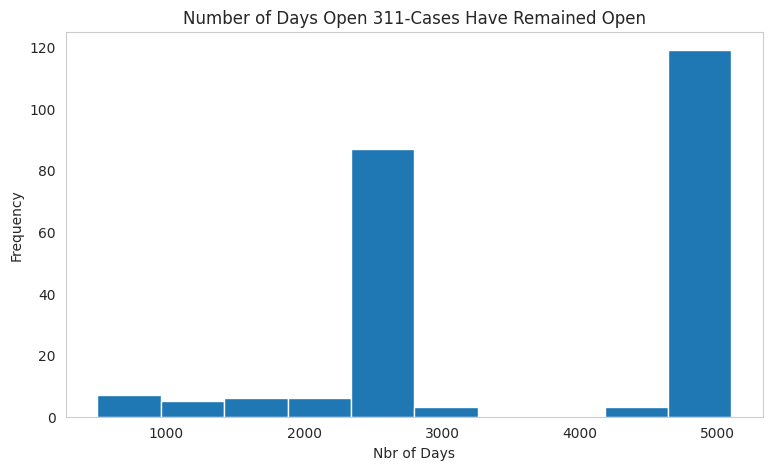

In [427]:
# hist to visaulize nbr of days open cases have remained open

# NOTE 
# Currently need to manually change the plot range to account 
# for range cases have been open, esp. in regard to the *mean*

sns.set_style("whitegrid", {'axes.grid' : False})
plt.title('Number of Days Open 311-Cases Have Remained Open')
plt.xlabel('Nbr of Days')
df_open['days_open'].plot(kind='hist', range=[500,5100], figsize=(9,5))
plt.show()

### Histograms processing time 

In [428]:
print('Quick stats on "processing days", use to set range on histogram')
print(df_closed.processing_days.agg([min, max, np.mean, np.median, statistics.mode]))

Quick stats on "processing days", use to set range on histogram
min          1.000000
max       1969.000000
mean        15.471016
median       3.000000
mode         1.000000
Name: processing_days, dtype: float64


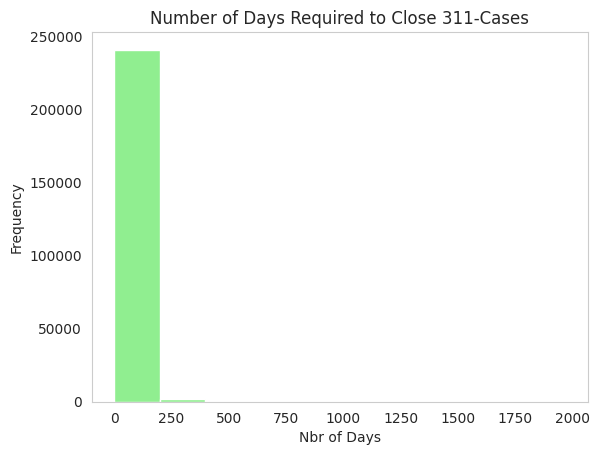

In [429]:
# hist to visualize processing time for cases that have been closed
plt.title('Number of Days Required to Close 311-Cases')
plt.xlabel('Nbr of Days')
df_closed['processing_days'].plot(kind='hist', color='lightgreen')
plt.show()
# frequency scale is too broad to show any detail

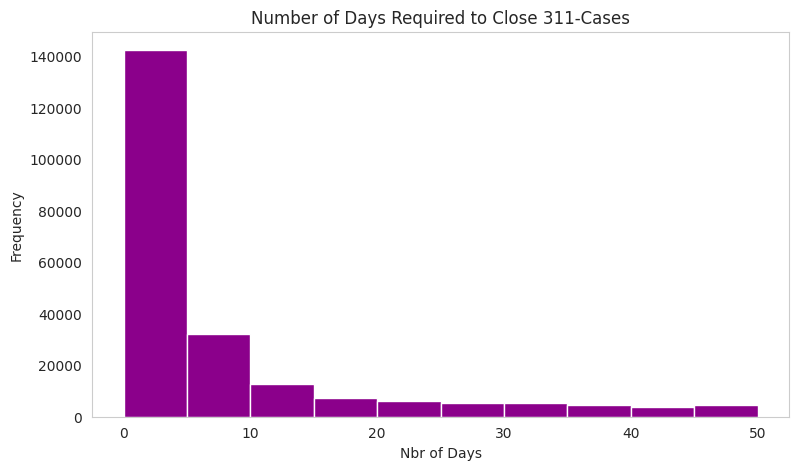

In [430]:
# hist to visualize processing time for cases that have been closed
plt.title('Number of Days Required to Close 311-Cases')
plt.xlabel('Nbr of Days')
df_closed['processing_days'].plot(kind='hist', range=[0,50], color='DarkMagenta', figsize=(9,5))
plt.show()

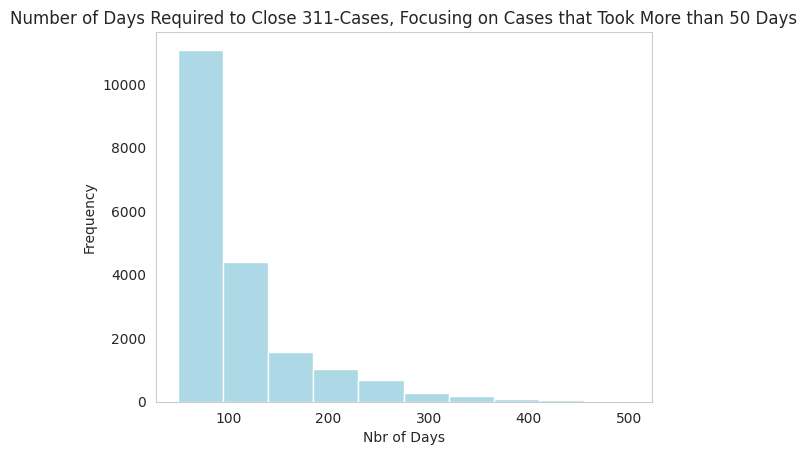

In [431]:
# hist to visualize processing time for cases that have been closed
plt.title('Number of Days Required to Close 311-Cases, Focusing on Cases that Took More than 50 Days')
plt.xlabel('Nbr of Days')
#df_closed['processing_days'].plot(kind='hist', range=[100,900], color='LightBlue')
df_closed['processing_days'].plot(kind='hist', range=[50,500], color='LightBlue')
plt.show()

In [432]:
df_proc_less_100 = df_closed[df_closed['processing_days']<100]
df_proc_more_100 = df_closed[df_closed['processing_days']>99]

print(df_proc_less_100.shape)
print(df_proc_more_100.shape)

(235079, 19)
(7628, 19)


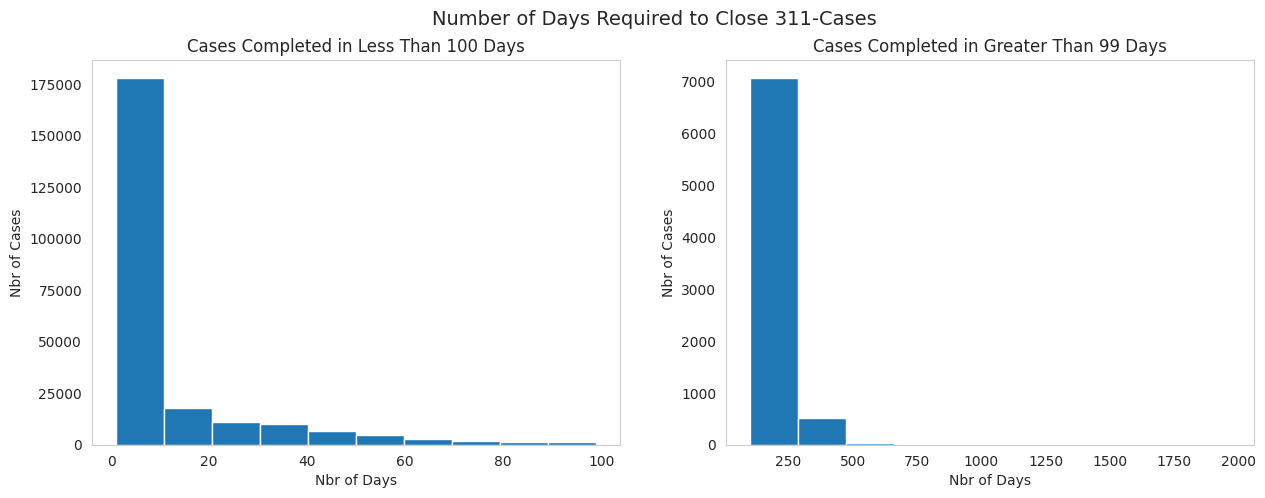

In [433]:
fig,ax =  plt.subplots(1,2, figsize=(15,5))

fig.suptitle('Number of Days Required to Close 311-Cases',fontsize=14)
ax[0].set(xlabel='Nbr of Days')
ax[1].set(xlabel='Nbr of Days')
ax[0].set(ylabel='Nbr of Cases')
ax[1].set(ylabel='Nbr of Cases')

ax[0].set_title('Cases Completed in Less Than 100 Days')
ax[1].set_title('Cases Completed in Greater Than 99 Days')

ax[0].hist(df_proc_less_100.processing_days)
ax[1].hist(df_proc_more_100.processing_days)
plt.show()

In [434]:
# break it into 3 blocks...
df_proc_less_50 = df_closed[df_closed['processing_days']<50]
df_proc_less_100 = df_closed[df_closed['processing_days'].between(50,100)]
df_proc_more_100 = df_closed[df_closed['processing_days']>99]

print(df_proc_less_50.shape)
print(df_proc_less_100.shape)
print(df_proc_more_100.shape)

(223323, 19)
(11867, 19)
(7628, 19)


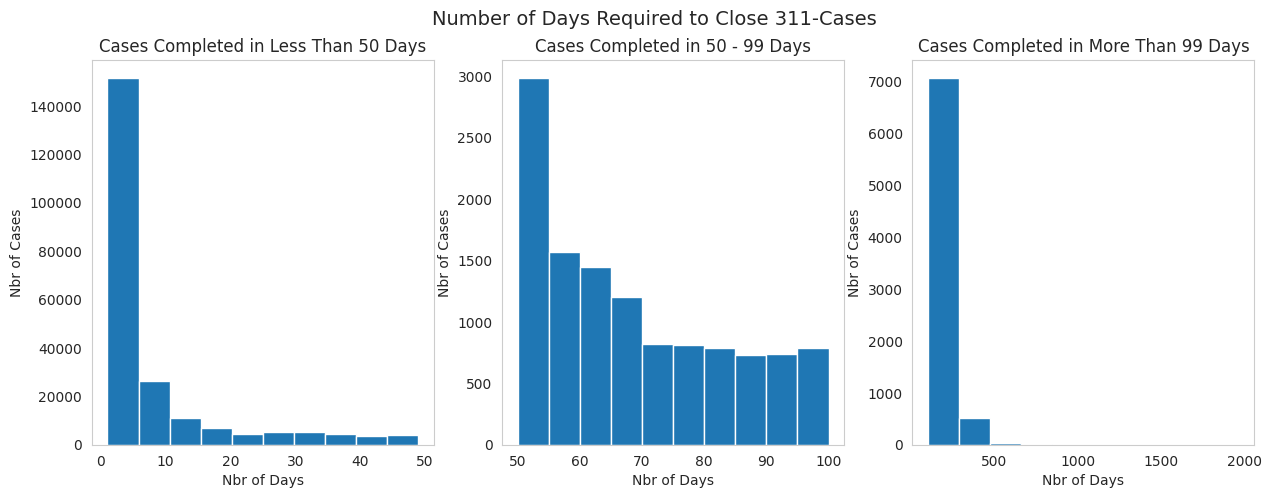

In [435]:
fig,ax =  plt.subplots(1,3, figsize=(15,5))
fig.suptitle('Number of Days Required to Close 311-Cases',fontsize=14)
for i in range(3):
  ax[i].set(xlabel='Nbr of Days')
  ax[i].set(ylabel='Nbr of Cases')
ax[0].set_title('Cases Completed in Less Than 50 Days')
ax[1].set_title('Cases Completed in 50 - 99 Days')
ax[2].set_title('Cases Completed in More Than 99 Days')

ax[0].hist(df_proc_less_50.processing_days)
ax[1].hist(df_proc_less_100.processing_days)
ax[2].hist(df_proc_more_100.processing_days)
plt.show()

# misleading because compares frequency scales that are completely diffefrent

In [436]:
del df_proc_less_50, df_proc_less_100, df_proc_more_100

### Plot, over time, nbr of days required to close cases

In [437]:
print('Processing days range:',df_closed.processing_days.min(),'to',df_closed.processing_days.max())

Processing days range: 1 to 1969


In [438]:
# Create df with aggregate stats for month & year (reset_index to make opened_month_year a col)
grouped_df = df_closed.groupby('opened_month_year')['processing_days'].agg([np.mean, min, max]).reset_index()

# chg col names: 'process_mean' refers to mean nbr of days required to close a 311-case
grouped_df.rename(columns={'mean': 'closing_days_mean', 'min': 'closing_days_min', 'max':'closing_days_max'},inplace=True)
grouped_df.head()

,opened_month_year,closing_days_mean,closing_days_min,closing_days_max
0,2009-05,13.666667,1,31
1,2009-07,13.125000,1,72
2,2009-08,19.857921,1,489
3,2009-09,20.703872,1,482
4,2009-10,22.738536,1,449


In [439]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype    
---  ------             --------------  -----    
 0   opened_month_year  97 non-null     period[M]
 1   closing_days_mean  97 non-null     float64  
 2   closing_days_min   97 non-null     int64    
 3   closing_days_max   97 non-null     int64    
dtypes: float64(1), int64(2), period[M](1)
memory usage: 3.2 KB


In [ ]:
# Visualize nbr of days it took to close cases, over time

# ISSUE [TODO]

# What was I trying to do here???

# when more recs were read time frame expaned; now x-axis labels are too close together
# could this be switched to the year, rather than the month?
# to do that, would need to create new col for year opened, then groupby that col

labels = grouped_df.opened_month_year.dt.strftime('%m:%Y').astype(str)
x = grouped_df.closing_days_max.max()
x_max = int(math.ceil(x / 100.0)) * 100

fig, ax = plt.subplots(3,1, figsize=(18,12))
for i in range(3):
  ax[i].set(ylabel='Nbr of Days')
  ax[i].set_xticklabels(labels, rotation='vertical')
  ax[i].set(xlabel='Date Case Was Opened')
  ax[i].set_ylim([0, x_max]) # makes y scale same on all 3

ax[0].set_title('Minimum Number of Days Required to Close Cases, Over Time')
ax[1].set_title('Maximum Number of Days Required to Close Cases, Over Time')
ax[2].set_title('Mean Number of Days Required to Close Cases, Over Time')
fig.tight_layout(pad=4.0)
'''
annotate start of pandemic?
ax.annotate('pixel offset from axes fraction',
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
'''
ax[0].plot(grouped_df.opened_month_year.dt.strftime('%m:%Y'), grouped_df.closing_days_min, color='g')
ax[1].plot(grouped_df.opened_month_year.dt.strftime('%m:%Y'), grouped_df.closing_days_max, color='r')
ax[2].plot(grouped_df.opened_month_year.dt.strftime('%m:%Y'), grouped_df.closing_days_mean, color='b')
plt.show()

In [441]:
# Create df with aggregate stats for month & year (reset_index to make opened_month_year a col)
year_df = df_closed.groupby('opened_year')['processing_days'].agg([np.mean, min, max]).reset_index()

# chg col names: 'process_mean' refers to mean nbr of days required to close a 311-case
year_df.rename(columns={'mean': 'closing_days_mean', 'min': 'closing_days_min', 'max':'closing_days_max'},inplace=True)
year_df.head()

,opened_year,closing_days_mean,closing_days_min,closing_days_max
0,2009,20.665582,1,489
1,2010,15.697431,1,358
2,2011,22.616438,1,1172
3,2012,39.176471,1,272
4,2013,349.250000,1,983


In [442]:
del grouped_df

In [ ]:
# same visualization, but at yearly intervals
# NOTE that the y-axis scales are NOT the same

#TODO change this to match the current way I populate opened_year

#labels = year_df.opened_year.dt.strftime('%Y').astype(str)
labels = year_df.opened_year.astype(str)

x = year_df.closing_days_max.max()
x_max = int(math.ceil(x / 100.0)) * 100

fig, ax = plt.subplots(3,1, figsize=(18,12))
for i in range(3):
  ax[i].set(ylabel='Nbr of Days')
  ax[i].set_xticklabels(labels)
  ax[i].set(xlabel='Year Case Was Opened')
#  ax[i].set_ylim([0, x_max]) # makes y scale same on all 3

ax[0].set_title('Minimum Number of Days Required to Close Cases, Over Time')
ax[1].set_title('Maximum Number of Days Required to Close Cases, Over Time')
ax[2].set_title('Mean Number of Days Required to Close Cases, Over Time')
fig.tight_layout(pad=4.0)

ax[0].plot(year_df.opened_year.dt.strftime('%Y'), year_df.closing_days_min, color='lightgreen')
ax[1].plot(year_df.opened_year.dt.strftime('%Y'), year_df.closing_days_max, color='plum')
ax[2].plot(year_df.opened_year.dt.strftime('%Y'), year_df.closing_days_mean, color='lightblue')
plt.show()

### Changes over time: has the source changed over time?

### Plot closed cases 
  as a Series by: 

*   Responsible Agency
*   Category
*   Request Type
*   Supervisor District
*   Neighborhood
*   Police Disctrict




In [ ]:
# plot CLOSED cases (as a Series) by: Responsible Agency, Category, 
#  Request Type, Supervisor District, Neighborhood, Police District
# 'ranking relationship' so using horizontal bar graphs
# for Supervisor District, maybe join to diff table to get supervisor name (based on date)?

elements = ['Responsible Agency','Category', 'Request Type',
            'Supervisor District', 'Neighborhood', 'Police District']

for el in elements:
  plt.title('Most Common '+ el+' for Closed 311-Cases')
  plt.xlabel('Count')
  df_closed[el].value_counts().nlargest(n=8).sort_values().plot(kind='barh',color='g')
  plt.show()


### Plot open cases 
 as a Series by: 

*   Responsible Agency
*   Category
*   Request Type
*   Supervisor District
*   Neighborhood
*   Police Disctrict

In [ ]:
#  Supervisor District (could join to a diff table to get supervisor name)
# 'ranking relationship' so using horizontal bar graphs

# When considering 'open' cases, focus on cases that have remained open for a lengthy period
# (If a case opened yesterday is still open, that doesn't indicate an issue)

# only consider cases open for at least a year...
df_open_long = df_open[df_open['time_open'].astype('timedelta64[D]') > 365]

for e in elements:
  plt.title('Most Common '+ e+' for Open 311-Cases')
  plt.xlabel('Count')
  df_open_long[e].value_counts().nlargest(n=8).sort_values().plot(kind='barh', color='r')
  plt.show()

## **Question**: Are the most common Closed case types the same as the most common Open case types? Should I be looking at percentages instead? Relative to total number of cases?

## Correlation between [something?] and 'closure rate'
### must define 'closure rate'